<a href="https://colab.research.google.com/github/RahmanKhorramfar91/UAI_Case_Studies/blob/main/Case_Study_1_UAI_AI_and_Sustainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study 1 - Universal AI, AI and Sustainability: Energy**


This case study is prepared by [Rahman Khorramfar](https://www.rahmankhorramfar.com/) for the ***AI and Sustainability: Energy*** module instructed by Professor [Saurabh Amin](https://cee.mit.edu/people_individual/saurabh-amin/). The module is part of the Universal AI course.

My email for questions, suggestions, and comments: khorram@mit.edu

## About the Case Study

The main task for learners is to develop effective forecasting models for the medium- and long-term projection of electric power demand for the ISONE region.
The medium-term forecast is defined as the hourly demand over the course of one week. For simplicity, we will assume that this specific week is the last week of the year. The long-term forecast involves projecting demand for a future target year, which means generating hourly demand data for an entire year based on historical data

To better achieve these tasks and supplement the lecture material, this case study is presented in a tutorial style covering baseline forecasting methods, ARIMA/SARIMA, XGBoost, and LSTM/GRU techniques. It also briefly covers accuracy measures, hyperparameter tuning, and feature engineering.

**Overview of the content**:

1. [Definitions and Basic Concepts](#definitions)
2. [Getting Started](#getting_started)
3. [Baseline: Moving Average (Rolling Average)](#baseline)
4. [ARIMA/SARIMA](#arima)
5. [XGBoost](#xgboost)
6. [LSTM and GRU](#lstm)
7. [Case Study Questions](#questions)
9. [References and Further Reading](#references)

# **<font color='blue'>1. Definitions and Basic Concepts </font>** [<a name="definitions"></a>](https://)
- **Forecasting**: is a common task in energy systems and refers to the process of predicting the future parameters, given any relevant knowledge of the past. Forecasting helps to inform decisions in all levels of energy systems planning and optimization. It is roughly categorized into very-short-term (minutes to hours), short-term (hours to day), medium-term (days to weeks), and long-term (weeks to years).  

- **Time Series**: a set of time-indexed data points where each point represents a measurement or observation at a specified time. A time series is *univeratiate* if at each time period a single data point is recorded, and is *multivariate* otherwise.

- **Stationary**: a time series is stationary if the joint distribution over any set of consequitive samples is the same. In other words, the statistical properties (mean, standard deviation, autocovariance) of the timer series does not change over time.

- **Trend**: underlying pattern in non-stationary time series and refers to long-term gradual changes in the data (linear upward, linear downward, nonlinear)

- **Seasonality**: refers to regular and repeating patterns occuring at fixed itnervals (daily, weekly, etc.)

- **Response variable**: is the predicted variable. This variable also known as as dependent, target, internal, forecast, predicted, observed, Y-variable, and endogenous variable.

- **Covariate**: variable(s) help predict or explain the response variable. These variables also known as predictors, regressors, explanatory, exogenous, external, X-variable, and feature variables.

- **َAutocorrelation**: correlation between a variable at a specific time period and its lagged values. The analysis of autocorrelation helps to determine pattern, dependencies, and seasonality in the data.


## Accuracy Metrics and Evaluation Criteria

Depending on the context and applications, different metrics can be used to measure the performance of a forecasting models. Some of the widely used metrics are Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE). The impact of the forecasted points on the downstream task can also be used as an indication of the moder performance, as we will see in this case study.  
<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>2. Getting Started </font>**  <a name="getting_started"></a>
This case study is prepared to be in a tutorial style, and self-contained as much as possible. The case study is applied to the historical data from the New England region of the US. The data is available at the [ISO New England (ISONE) website](https://www.iso-ne.com/system-planning/planning-models-and-data/variable-energy-resource-data/) under *2024_isone_variable_energy_resource_ver_data_series_2000-2023_rev1*. The dataset contains hourly time series data for load, wind, and solar between 2000 and 2023 (24 years) for 8 New England zones, as well as the aggregated values. for the entire region. For the sake of this case study, we selected the aggregated load time series for ISONE and curated the data slightly for better readibility. The curated data is available at the GitHub page for the case studies.

We will begin by summoning the required packages and continue with recalling and processing the data. For each technique, a very brief description is provided.

## Recall the required packages
include packages for data science and scientific computing, specialized forecasting, deep learning, file management, and operating system packages.

In [ ]:
import numpy as np; # for scientific computing
import pandas as pd; # for data science
import matplotlib.pyplot as plt; # for plotting
from statsmodels.tsa.seasonal import seasonal_decompose; # for statistical models including forecasting
from statsmodels.tsa.stattools import adfuller;
from statsmodels.tsa.arima.model import ARIMA;
import xgboost as xgb; # for XGBoos technique
from xgboost import plot_importance, plot_tree;
import os; # os: for directory control
import zipfile; # to handle zip files
import tensorflow as tf; # tensorflow
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import *;
from tensorflow.keras.callbacks import ModelCheckpoint;
from tensorflow.keras.losses import MeanSquaredError;
from tensorflow.keras.metrics import RootMeanSquaredError;
from tensorflow.keras.optimizers import Adam;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf; # for ACF and PACF plots

## Download and Unzip the Data
Clone the curated load data from GitHub repositorty for the case studies. Unzip the file in a designated folder.

In [ ]:
!git clone 'https://github.com/RahmanKhorramfar91/UAI_Case_Studies.git';

Cloning into 'UAI_Case_Studies'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 20 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 13.91 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
zip_file_path = os.getcwd()+'/UAI_Case_Studies/load_time_series_data.zip';
extract_dir = os.getcwd()+'/load_time_series_data';
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data Preview and Preprocessing
Read the data for a particular year and add some temporal features (week of the year, day of week, etc.) to the dataset.

In [ ]:
yr = 2020;
zone = 'ISONE';
data = pd.read_csv(f'/content/load_time_series_data/load_time_series_data/{yr}_{zone}_load.csv');
data.head(3)

,Unnamed: 0,date,hour_of_day,gross_load_MW,temperature_C,relative_humidity,global_horizontal_irradiance,10m_wind_speed
0,0,2020-01-01,1,11441.992,2.500,75.127,0.0,3.778
1,1,2020-01-01,2,11021.235,1.783,73.678,0.0,3.924
2,2,2020-01-01,3,10717.157,1.116,76.683,0.0,3.993


In [ ]:
# add temporal features
data['hour_of_year'] = data.index+1;
data.index = pd.to_datetime(data.date);
data['date'] = data.index;
data['year'] = data['date'].dt.year;
data['day_of_week'] = data['date'].dt.dayofweek;
data['quarter_of_year'] = data['date'].dt.quarter;
data['month'] = data['date'].dt.month;
data['day_of_year'] = data['date'].dt.dayofyear;
data['week_of_year'] = data['date'].dt.dayofyear//7 + 1;

## Define Plotting and Evaluation Functions

In [ ]:
def return_accuracy_metrics(test, forecasted):
    '''
    Parameters
    ----------
    test : numpy array, the vector of test set (real positive values)
    forecasted : numpy array, the forecasted values (real positive values)
    OUTPUT: three commonly used accuracy metrics, namely RMSE, MAE, and MAPE
    '''
    if test.shape!= forecasted.shape:
      test = test.reshape(-1);
      forecasted = forecasted.reshape(-1);

    # calculate error metrics
    RMSE = np.sqrt(np.mean((test - forecasted)**2));
    MAE = np.mean(np.abs(test - forecasted));
    MAPE = np.mean(np.abs((test - forecasted) / test))*100;

    print(f'Point Accuracy Metrics\n \t RMS: {np.round(RMSE,2)}, MAE: {np.round(MAE,2)}, MAPE: {np.round(MAPE,2)}');
    return RMSE, MAE, MAPE;

In [ ]:
def plot_and_report_accuracy_metrics(test, forecasted, days_to_show):
    '''
    Parameters
    ----------
    test : numpy array, the vector of test set (real positive values)
    forecasted : numpy array, the forecasted values (real positive values)
    days_to_show : number of days to contrast the hourly date between actual and forecasted values

    plot the actual vs. forecasted values for the next 'days_to_show' number of days
    and report the three commonly used accuracy metrics, namely RMSE, MAE, and MAPE
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4),
                            gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                                        'wspace': 0.1,'hspace': 0.1});

    ax.plot(np.arange(days_to_show*24), test[:days_to_show*24], color='xkcd:warm blue', label='Actual')
    ax.plot(np.arange(days_to_show*24), forecasted[:days_to_show*24], color='xkcd:vermillion', label='Forecasted')

    ax.set_xlabel('Hour');
    ax.set_ylabel('Gross Load (MW)',fontsize=14);
    ax.legend(loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1), prop={'size': 12});

    if test.shape!= forecasted.shape:
      test = test.reshape(-1);
      forecasted = forecasted.reshape(-1);

    # calculate error metrics
    RMSE = np.sqrt(np.mean((test - forecasted)**2)); # Root mean square deviation
    MAE = np.mean(np.abs(test - forecasted)); # Mean absolute error
    MAPE = np.mean(np.abs((test - forecasted) / test))*100; # Mean absolute percentage error

    print(f'Point Accuracy Metrics\n \t RMSE: {np.round(RMSE,2)}, MAE: {np.round(MAE,2)}, MAPE: {np.round(MAPE,2)}%');

<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>3. Baseline: Moving Average (Rolling Average) </font>** <a name="baseline"></a>
Moving Average (MA) methods are used for forecasting future values based on the average of a set of past data. MA methods are used for short-term forecasting, usually less than the next 4 periods. Nevertheless, we will apply it to forecast for the next one week, just to provide a baseline of comparison with other methods.

The **Simple Moving Average** (SMA) forecasting formula predicts the next value based on the average of the previous $p$ values in the time series:

$\hat{y}_{t} = \frac{1}{p} \sum_{i=1}^{p} y_{t-i}$

Where:

- $ \hat{y}_{t}$: forecasted value at time $t$
- $y_{t-i}$: past observations
- $p$: window size

Closely related is the **Weighted Moving Average** (WMA) method:

$\hat{y}_{t} = \frac{1}{p} \sum_{i=1}^{p}w_i y_{t-i}$

 which weights the observations with $w_\tau$. A special case of WMA is **Exponential Smoothing** defined as:

 $\hat{y}_{t} = \frac{1}{p} \sum_{i=1}^{p} \rho^{i} y_{t-i}$



## Implementation

In [ ]:
# Split the data into train and test sets for both load and selected covariates
train_size = 51*7*24; # medium term forecasting for the one week (last week) of the year
exog_columns = ['temperature_C', 'global_horizontal_irradiance', '10m_wind_speed','day_of_year','hour_of_year','week_of_year'];
train_load, test_load = data['gross_load_MW'][:train_size], data['gross_load_MW'][train_size:];
train_exog, test_exog = data[exog_columns][:train_size], data[exog_columns][train_size:];
print(type(test_load));

<class 'pandas.core.series.Series'>


Point Accuracy Metrics
 	 RMSE: 2252.6, MAE: 1782.16, MAPE: 14.68%


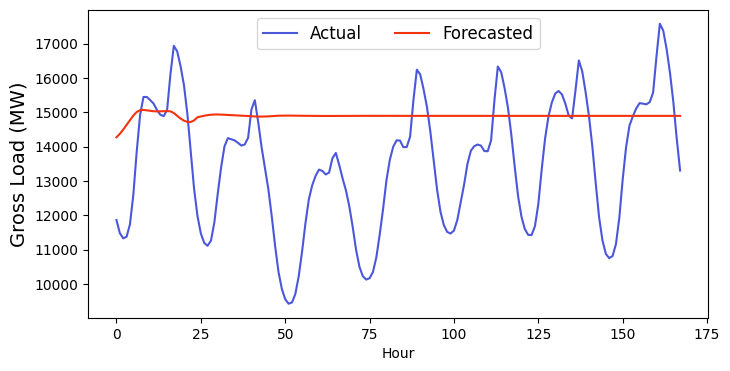

In [ ]:
# apply the simple moving average
window_size = 24;
forecast_period = len(test_load);
forecasted = np.zeros(forecast_period);
for t in range(len(forecasted)):
    s1 = 0;
    if window_size>t:
      s1 += train_load[-window_size+t:].sum()
    s1 += np.sum(forecasted[max(0,t-window_size):t]);
    forecasted[t] = s1/window_size;

plot_and_report_accuracy_metrics(test_load.to_numpy(), forecasted, 7);

---
**<font color='red'>Question 1: </font>** extend the method for weighted average and average smoothing methods.

how these models be modified to handle seasonality and trends?

how to make these models to work for multivariate forecasting?

provide another baseline with multivariate regression

<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>4. ARIMA/SARIMA </font>** <a name="arima"></a>
 ARIMA and its seasonal variant, SARIMA are among the most notable statistical forecasting models. Here, we first introduce their building blocks and then introduce some heuristic rules to tune their hyperparameters. We wrap this section with the Python implementation and the ensuing questions.


Let's start with

- Large p and q can result in overfitting

https://towardsdatascience.com/time-series-models-d9266f8ac7b0/

https://r4ds.github.io/bookclub-fpp/difference-between-stochastic-and-deterministic-trends.html



## Building Blocks
ARIMA/SARIMA stands for (Seasonal) AutoRegressive Integrated Moving Average. The model is composed of two component, namely autoregressive and moveing average, and has one feature, namely integrated. The underlying assumption in many statistical forecasting models is the staionarity of the data.

**Autoregressive (AR)** component that models the relationship between the future forecast and its past observation. AR component is usually linear function of a constant $c$, weighted combination of past observations up to order $p$, and white noise $\epsilon_t$. The term *white noise* refers to a sequence of random variables that are uncorrelated, have a mean of zero, and a constant variance.

$y_{t} = c+ \sum_{i=1}^{p}\alpha_i y_{t-i} + \epsilon_t$

Autoregressive model of order $p$ is denoted by $AR(p)$.

<br>

**Moving Average (MA)** similar to AR but instead of past observation, past forecast errors are used:

$y_{t} = c+ \sum_{i=1}^{q}\beta_i \epsilon_{t-i} + \epsilon_t$

Moving average model of order $q$ is denoted as $MV(q)$

<br>

**Integrated** feature differences two consecutive data points in an attempt to make the time series stationary. This feature can only make the statistical average (mean) constant. However, if the variance still remain dynamic other methods such as Box-Cox transformation is applied which is not covered here. The number of times the data is differences is denoted by $d$ parameter.


## ARIMA Model

ARIMA combines the AR and MV with itegrated feature. Therefore, letting $y' = y_t-y_{t-1}$ to represent the integrated feature, the the ARIMA$(p, d, q)$ model is

$y'_{t} = c+ \sum_{i=1}^{p}\alpha_i y'_{t-i} + \sum_{i=1}^{q}\beta_i \epsilon_{t-i} + \epsilon_t$



## ACF and PACF
Autocorrelation quantifies the linear relationship between a time series and its past values (lagged values). The analysis of autocorrelation is fundamental for model selection in ARIMA/SARIMA. Two widely used autocorrelation-based measures are autocorrelation function (ACF) and partial autocorrelation function (PACF).

**ACF** quantifies the correlation of a time series with its lags ($y_t$ and $y_{t-k}$, for $k=1, 2, \ldots$)

$r_k = \frac{Cov(y_y, y_{t-k})}{\sqrt{Var(y_t)Var(y_{t-k})}} = \frac{\sum_{t=k+1}^{T}(y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^{T}y_t-\bar{y}}$

<br>

**PACF** quantifies the correlation of time series with its lags, removing the influence of intermediate lags. For example, if $y_t$ and $y_{t-1}$, and $y_{t-1}$ and $y_{t-1}$ are correlatd, the partial correlation between $y_{t-2}$ and $y_t$ is the quantity that is not explain by their relationship with $y_{t-1}$.


$r'_k = \frac{Cov(y_y, y_{t-k}|y_{t-1}, y_{t-2}, \ldots, y_{t-k+1})}{\sqrt{Var(y_t|y_{t-1}, y_{t-2}, \ldots, y_{t-k+1})Var(y_{t-k}|y_{t-1}, y_{t-2}, \ldots, y_{t-k+1})}}$

<br>

**ACF and PACF Plots**: these plots help identify the patterns (stationarity, seasonality and trend) and dependencies (order of $p$ and $q$ values in the AR and MV models). There are some rule of thums to help with the anlysis and model selection. Given a stationary model, there are some rule of thums to choose possible values for $p$ and $q$ in ARIMA/SARIMA:
- ARIMA($p, d, 0$) is suggested if ACF is decaying gradually and PACF spikes at lag $p$ but not beyond
- ARIMA($0, d, q$) is suggested if PACF is decaying gradually and ACF spikes at lag $q$ but not beyond
-  The lag at which the ACF plot is cut off (beyong which become insignificant) is $q$
- The lag at which the PACF plot is cut off is $p$




## Checking for Staionarity

There are two main ways to check the stationary of a time series including

1. **Visual inspection**: trend and seasonality are signs of non-stationarity. Moreover, a decaying or fluctuating ACF plots indicates trend and seasonality.

2. **Statistical test**: Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests are commonly used metrics.

## SARIMA Model
Although ARIMA can be effective for timer series with seasonality, its functionality may degrade for longer seasonal cycles. SARIMA, instead, explicitly models seasonality potentially leading to better accuracy and interpretabilty.

$y'_{t} = c+ \sum_{i=1}^{p}\alpha_i y'_{t-i} + \sum_{i=1}^{q}\beta_i \epsilon_{t-i} + \sum_{i=1}^{P}\gamma_i y'_{t-mi} + \sum_{i=1}^{Q}\delta_i y_{t-mi} +\epsilon_t$

where $p$ and $q$ are the same as ARIMA; $P$ and $Q$ are the oders of seasonal AR and MV, and $m$ is the length of the season. Therefore, a SARIMA model is characterized by parameters ($p, d, q$) ($P, D, Q$)$m$


## Step-by-Step Procedure, Best Practices, and Challenges

Guid to apply autoregressive models:
1. Visualize and examine the data for stationarity, trend, outliers, and missing values.
2. If needed, transform the data stationary by stabilizing the mean and variance
2. Use ACF and PACF plots to estimate potential values for the model parameters
3. Apply ARIMA/SARIMA
4. Fine tune the model by forecast-specific (RMSE, MAE, etc.) and if needed, task-baed metrics (downstream task in which the forecasted values are used). Grid search and Bayesian optimization are common fine-tuning mechanisms.

Best practices:
- Start simple and increase the complexity if required. Simpler models are easier to interpret.
-

## Implementation

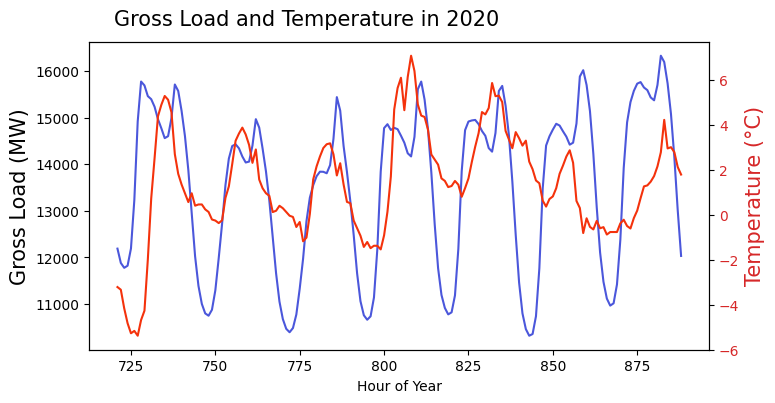

In [ ]:
# visualize the data

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4),
                        gridspec_kw={'width_ratios': [10],'height_ratios': [5],
                                    'wspace': 0.1,'hspace': 0.1});
font_size = 15;
hours_to_plot = range(30*24, 37*24); # use range(len(data)) for the entire year
ax.plot(data['hour_of_year'].iloc[hours_to_plot], data['gross_load_MW'].iloc[hours_to_plot],
        color='xkcd:warm blue', label='Gross Load (MW)');
ax.set_xlabel('Hour of Year');
ax.set_ylabel('Gross Load (MW)', fontsize=font_size);

# Create a second y-axis for temperature
ax2 = ax.twinx()
ax2.plot(data['hour_of_year'].iloc[hours_to_plot], data['temperature_C'].iloc[hours_to_plot],
         color='xkcd:vermillion', label='Temperature (°C)');
ax2.set_ylabel('Temperature (°C)', color='tab:red', fontsize=font_size);
ax2.tick_params(axis='y', labelcolor='tab:red');

# Titles and layout
ax.text(hours_to_plot[0], 1.04*np.max(data['gross_load_MW'].iloc[hours_to_plot]),'Gross Load and Temperature in 2020', fontsize=font_size);

The above figure clearly shows cyclic patterns, but no obvious trend is visible. Next, we divide the time series into train and test datasets and carry out the stationarity test using ACF/PACF plots and ADF method.

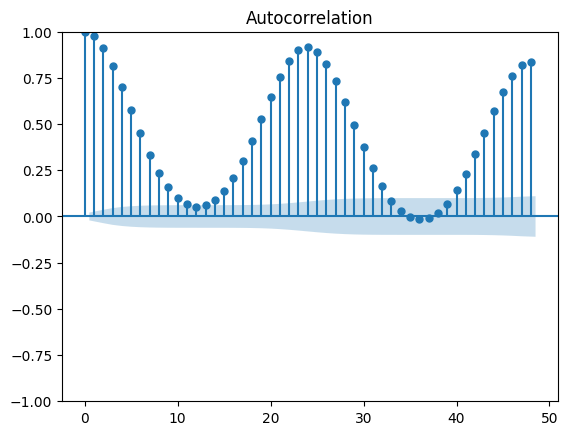

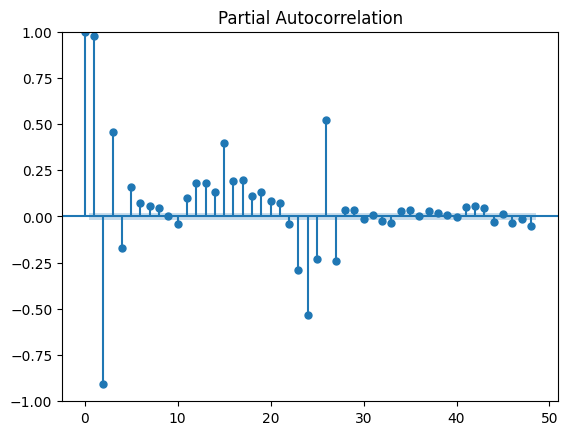

In [ ]:
# ACF and PACF plots
fig1 = plot_acf(train_load, lags=48);
fig2 = plot_pacf(train_load, lags=48);
# fig1.set_size_inches(10,4);
# fig2.set_size_inches(10,4);

Again, the seasonality is obvious from ACF plot, but there is no visual sign for any trend. Let's try out ADF test.

In [ ]:
# Perform Dickey-Fuller test on the gross load time series
def perform_DF_test(dat):
    adf_result = adfuller(dat, autolag='AIC');
    # Summarize the results
    result_description = ['ADF stats: ', 'p_value: ', 'Used lag: ','Number of observations: ','Critical values: ']
    for ri,rd in enumerate(result_description):
        print(f'{rd} {adf_result[ri]}');

perform_DF_test(train_load);

ADF stats:  -5.32707671573667
p_value:  4.81106954329659e-06
Used lag:  37
Number of observations:  8530
Critical values:  {'1%': np.float64(-3.431116854509938), '5%': np.float64(-2.8618788976454943), '10%': np.float64(-2.566950390305782)}


From the ADF test results, the p-value is small enough to reject the null hypothesis that the data is non-stationary. Nevertheless, we use differencing to see the effect.

ADF stats:  -16.28939582554627
p_value:  3.3501191064096257e-29
Used lag:  36
Number of observations:  8530
Critical values:  {'1%': np.float64(-3.431116854509938), '5%': np.float64(-2.8618788976454943), '10%': np.float64(-2.566950390305782)}


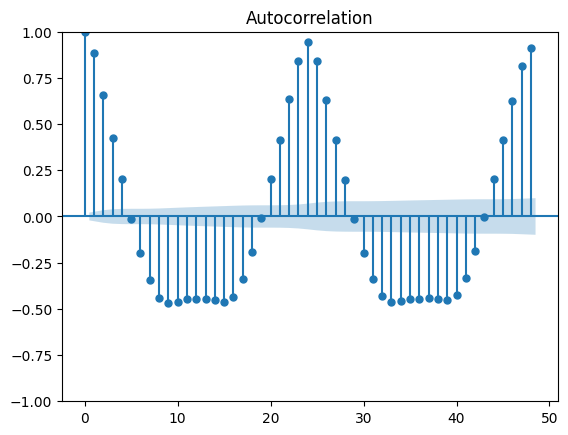

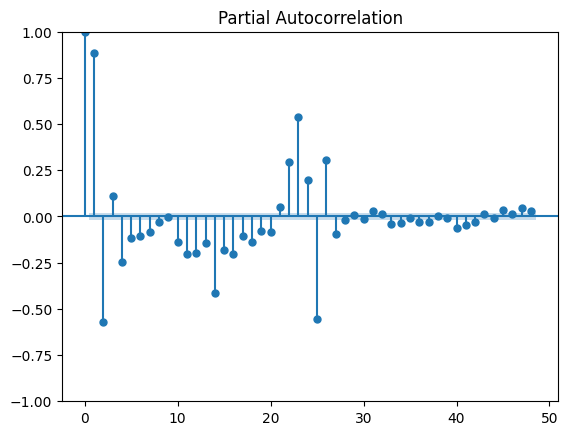

In [ ]:
train_diff = train_load.diff().dropna();
fig1 = plot_acf(train_diff, lags=48);
fig2 = plot_pacf(train_diff, lags=48);
perform_DF_test(train_diff);

The differencing made the ADF to more strongly reject the stationarity of the dataset. The analysis

Next, we apply ARIMA for univariate time series.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Point Accuracy Metrics
 	 RMSE: 1770.31, MAE: 1465.43, MAPE: 11.55%


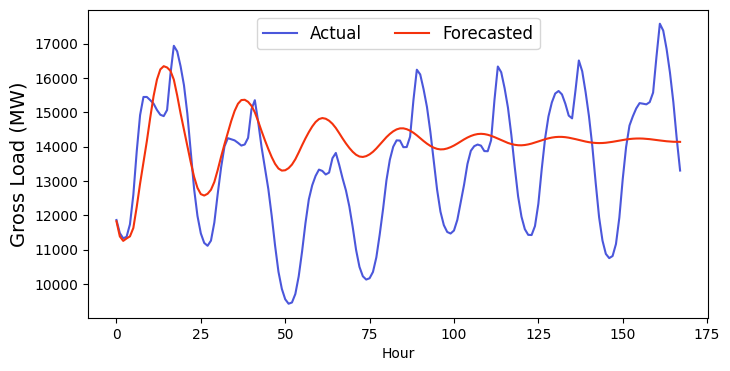

In [ ]:
# ARIMA for univariate time series (only load)
arima = ARIMA(train_load.to_numpy(), order=(12, 1, 8));
fitted_arima = arima.fit(method_kwargs={'maxiter':10});

# Perform forecasting on the training set
forecasted = fitted_arima.predict(start=len(train_load), end=len(data)-1);
plot_and_report_accuracy_metrics(test_load.to_numpy(), np.array(forecasted), 7);

Next, we apply ARIMA for the load time series, but we also want to use the covariates available. ARIMA with exogenous variables also called ARIMAX.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Point Accuracy Metrics
 	 RMSE: 2436.92, MAE: 1850.47, MAPE: 14.84%


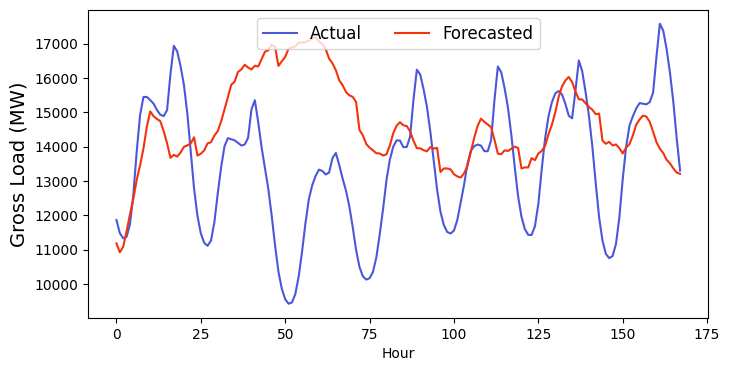

In [ ]:
# ARIMA for multivariate time series (load and its selected covariates)
arima = ARIMA(train_load.to_numpy(), order=(12,1,8), exog=train_exog.to_numpy());
fitted_arima = arima.fit(method_kwargs={'maxiter':10});

# Perform forecasting on the training set
forecasted = fitted_arima.predict(start=len(train_load), end=len(data)-1, exog=test_exog);
plot_and_report_accuracy_metrics(test_load.to_numpy(), forecasted, 7);

Next, we apply SARIMA for the load time series.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Point Accuracy Metrics
 	 RMSE: 1050.76, MAE: 773.38, MAPE: 5.96%


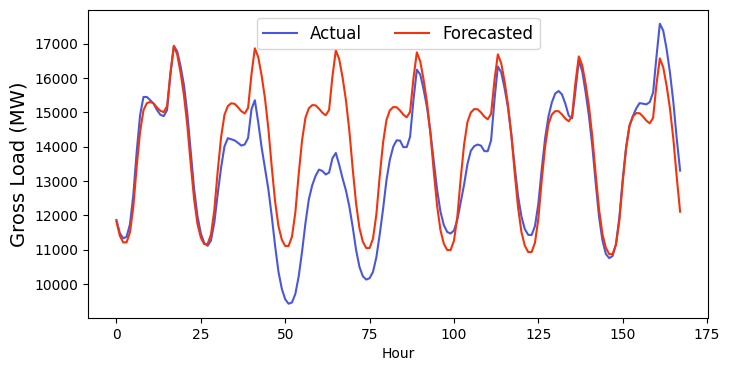

In [ ]:
# SARIMA for univariate time series
arima = ARIMA(train_load.to_numpy(), order=(4,1,2), seasonal_order=(1, 1, 1, 24));
fitted_arima = arima.fit(method_kwargs={'maxiter':10});

# Perform forecasting on the training set
forecasted = fitted_arima.predict(start=len(train_load), end=len(data)-1);
plot_and_report_accuracy_metrics(test_load.to_numpy(), forecasted, 7);

Next, we apply SARIMA for the load time series considering its covariates. SARIMA with exogenous variables also called SARIMAX.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Point Accuracy Metrics
 	 RMSE: 1026.14, MAE: 753.98, MAPE: 5.8%


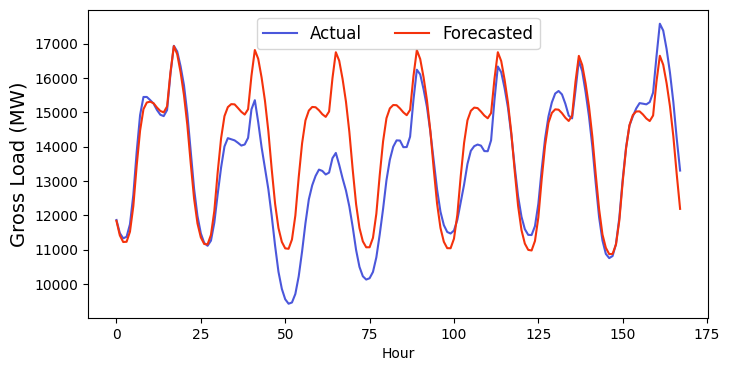

In [ ]:
# SARIMA for univariate time series
arima = ARIMA(train_load.to_numpy(), order=(4,1,2), seasonal_order=(1, 1, 1, 24), exog=train_exog.to_numpy());
fitted_arima = arima.fit(method_kwargs={'maxiter':10});

# Perform forecasting on the training set
forecasted = fitted_arima.predict(start=len(train_load), end=len(data)-1, exog=test_exog.to_numpy());
plot_and_report_accuracy_metrics(test_load.to_numpy(), forecasted, 7);

<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>5. XGBoost </font>** <a name="xgboost"></a>
XGBoost (eXtreme Gradient Boosting) is a powerful machine learning algorithm that can be used for forecasting applications. It combines multiple weak predictive models (e.g., decision trees) into to form a stonger model. Compared to traditional gradient boosting models, XGBoost is known for its high accuracy, computational efficiency, and enahnced regularization. Like many other forecasting methods, XGBoost assumes stationarity of the time series data. Luckily, the dataset used here is almost stationary, as out analysis showed in the previous section.

## Implementation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:18:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Point Accuracy Metrics
 	 RMSE: 2014.23, MAE: 1648.12, MAPE: 13.05%


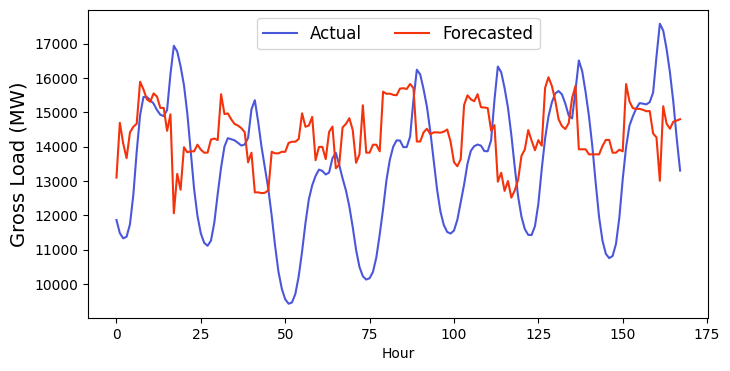

In [ ]:
#%% create XGBoos model
xgr = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       objective='reg:linear',# linear, squarederror
                       max_depth=5,
                       learning_rate=0.01);


xgr.fit(train_exog, train_load,
        eval_set=[(train_exog, train_load), (test_exog, test_load)],
        verbose = False);

forecasted = xgr.predict(test_exog);
plot_and_report_accuracy_metrics(test_load.to_numpy(), forecasted, 7);

Current XGBoost model performs poorly, perhaps not surprisingly because we know the data has seasonality which is a sign of non-stationary time series. However, there are a few ideas that can enhance the performance:
- Hyperparameter tuning: XGBoost comes with multitude of parameters some of which, such as the ones we considered in the initial model, can have a significant impact on its performance.

- Feature engineering: the current exogenous variables are basis. We can add new features such as lagged values of load and interaction terms (irradiance*wind speed). The lagged values seems perticularly useful as we already aware of the cyclic nature of the load and strong autocorrelation with closer data points. This may save us from apply de-seasonalizing the dataset.

In [ ]:
# add lagges to the dataset
def create_lagged_features(data, target_col, lags):
    data_lagged = data.copy()
    for lag in lags:
        data_lagged[f'{target_col}_lag_{lag}'] = data_lagged[target_col].shift(lag)
    # fill the nan values with average load
    return data_lagged.fillna(data_lagged.mean())
    # return data_lagged.dropna();
# Define the lags to include
lags = [1, 2, 24, 24*7] # Previous hour, 2 hours ago, same hour yesterday, same hour last week
# add lagged features
data_lagged = create_lagged_features(data.copy(), 'gross_load_MW', lags);

In [ ]:
# Update exogenous columns to include new lagged features and resplit the dataset
exog_columns_lagged = exog_columns + [f'gross_load_MW_lag_{lag}' for lag in lags];

# Split the data into train and test sets for both load and selected covariates
train_size = 51*7*24; # medium term forecasting for the one week (last week) of the year
train_load_lagged, test_load_lagged = data_lagged['gross_load_MW'][:train_size], data_lagged['gross_load_MW'][train_size:];
train_exog_lagged, test_exog_lagged = data_lagged[exog_columns_lagged][:train_size], data_lagged[exog_columns_lagged][train_size:];


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:18:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Point Accuracy Metrics
 	 RMSE: 234.58, MAE: 180.5, MAPE: 1.35%


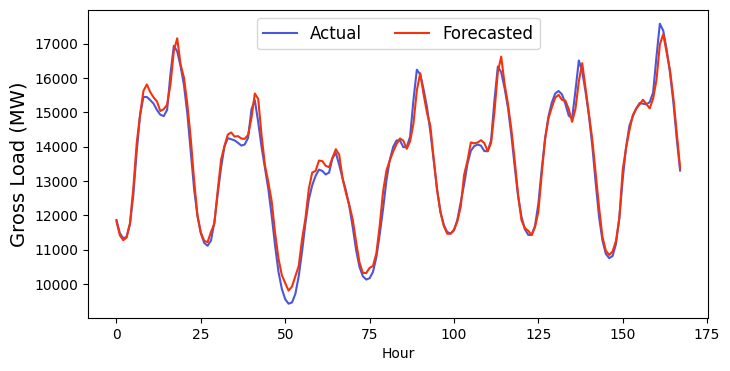

In [ ]:
#%% create XGBoos model
xgr = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       objective='reg:linear',# linear, squarederror
                       max_depth=5,
                       learning_rate=0.01);

xgr.fit(train_exog_lagged, train_load_lagged,
        eval_set=[(train_exog_lagged, train_load_lagged), (test_exog_lagged, test_load_lagged)],
        verbose = False);

forecasted = xgr.predict(test_exog_lagged);
plot_and_report_accuracy_metrics(test_load_lagged.to_numpy(), forecasted, 7);

<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>6. LSTM and GRU </font>** <a name="lstm"></a>
LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are both types of recurrent neural networks (RNNs) designed to handle long-term dependencies in sequential data. Here, we will apply LSTM and GRU to our example of predicting the power load for the next week, using a rather arbitrary configuration. To apply these concepts, we first prepare the data, split the dataset, normalize each set, and finally create the neural network architecture.

## Data Preparation
These models receive data as a series of *samples*, each consisting of past data points and corresponding output sequence. In time series where the data is given as a long sequence of data points (or data arrays), we can create multiple samples by the sliding windown trick to convert the data into a supervised learning task. For example, consider the sequence $3, 1, 4, 7, 2, 8, 5, 9, 6$. Given the window size of 4, the input samples are:

sample 1: $\quad X[0] = [3, 1, 4, 7], \qquad y[0]= 2$<br>
sample 2: $\quad X[1] = [1, 4, 7, 2], \qquad y[1]= 8$<br>
sample 3: $\quad X[2] = [4, 7, 2, 8], \qquad y[2]= 5$<br>
sample 4: $\quad X[3] = [7, 2, 8, 5], \qquad y[3]= 9$<br>
sample 5: $\quad X[3] = [2, 8, 5, 9], \qquad y[4]= 6$<br>

where $X$ is the input variables and $y$ is the label values (outputs). Once the samples are ready, the dataset is divided into training, validation, and test sets. The validation set is used for tuning the model parameters to avoid overfitting. As before, the test set is the dataset not seen by the model and is used by permormance measures.

The next step is to normalize the label values. The normalization step is importance to help the model train faster, and avoid numerical instabilities.


# Implementation

In [ ]:
# prepare the sequence
X = list(); y = list();
sliding_window_size = 4;
yX = data[['gross_load_MW']+ exog_columns].to_numpy();
for i in range(len(data)-sliding_window_size):
    slide = [s for s in yX[i:i+sliding_window_size]];
    X.append(slide);
    y.append(data['gross_load_MW'].iloc[i+sliding_window_size]);
X = np.array(X); y = np.array(y);
print(X.shape, y.shape);

(8780, 4, 7) (8780,)


In [ ]:
# train/validation/test split
train_size = 50*7*24;
val_size = 7*24;
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:];
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:];
y_train.shape, y_test.shape, X_train.shape, X_test.shape, y_val.shape, X_val.shape

((8400,), (212,), (8400, 4, 7), (212, 4, 7), (168,), (168, 4, 7))

In [ ]:
# normalize the label values
# X_train_mean = np.mean(X_train[:,:,0]);X_test_mean = np.mean(X_test[:,:,0]);
# X_train_std = np.std(X_train[:,:,0]);X_test_std = np.std(X_test[:,:,0]);

# y_train_mean = np.mean(y_train);y_test_mean = np.mean(y_test);
# y_train_std = np.std(y_train);y_test_std = np.std(y_test);

# X_train[:,:,0] = (X_train[:,:,0]-X_train_mean)/X_train_std;
# X_test[:,:,0] = (X_test[:,:,0]-X_test_mean)/X_test_std;
# y_train_normalized = (y_train - y_train_mean) / y_train_std;
# y_test_normalized = (y_test - y_test_mean) / y_test_std;

# normalize the label values
y_train_mean = np.mean(y_train); y_val_mean = np.mean(y_val); y_test_mean = np.mean(y_test);
y_train_std = np.std(y_train); y_val_std = np.std(y_val); y_test_std = np.std(y_test);

X_train_mean = np.mean(X_train, axis=(0, 1)); X_val_mean = np.mean(X_val, axis=(0, 1)); X_test_mean = np.mean(X_test, axis=(0, 1));
X_train_std = np.std(X_train, axis=(0, 1)); X_val_std = np.std(X_val, axis=(0, 1)); X_test_std = np.std(X_test, axis=(0, 1));

X_train = (X_train - X_train_mean) / X_train_std; X_val = (X_val - X_val_mean) / X_val_std; X_test = (X_test - X_test_mean) / X_test_std;
y_train = (y_train - y_train_mean) / y_train_std; y_val = (y_val - y_val_mean) / y_val_std;

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30)             │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,591 (17.93 KB)

 Trainable params: 4,591 (17.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.2178 - root_mean_squared_error: 0.4421 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2284
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1860
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0054 - root_mean_squared_error: 0.0731 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1655
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1528
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Point Accuracy Metrics
 	 RMSE: 269.06, MAE: 192.74, MAPE: 1.38%


((212,), (212, 1))

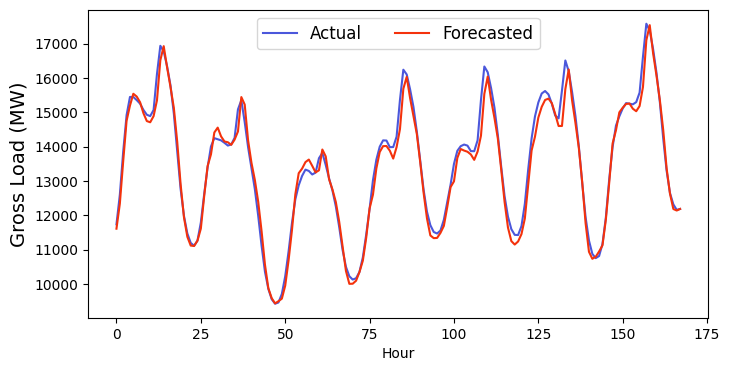

In [ ]:
# start with a simple model

Model = Sequential();
Model.add(InputLayer((sliding_window_size, len(exog_columns)+1)));
Model.add(LSTM(30));
Model.add(Dense(1, 'linear'));
Model.summary();

# Create the ModelCheckpoint callback
cp_lstm = ModelCheckpoint(
    filepath='/tmp/checkpoint/LSTM.keras',
    save_weights_only=False,  # Save the entire model
    # monitor='val_accuracy',   # Monitor validation accuracy
    # mode='max',               # Look for maximum validation accuracy
    save_best_only=True,      # Only save the best model
    # verbose=1                 # Display messages when saving
    );

Model.compile(optimizer=Adam(learning_rate=0.005), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()]);
Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp_lstm]);
# Load the best model and forecast
best_model = tf.keras.models.load_model('/tmp/checkpoint/LSTM.keras');
# Make forecast and inverse transform
forecasted_normalized = best_model.predict(X_test);
forecasted = np.array((forecasted_normalized * y_test_std) + y_test_mean);

plot_and_report_accuracy_metrics(y_test, forecasted, 7);
y_test.shape, forecasted.shape

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 4, 32)          │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,481 (119.07 KB)

 Trainable params: 30,481 (119.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.2612 - root_mean_squared_error: 0.4928 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2558
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0352 - root_mean_squared_error: 0.1877 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2177
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0274 - root_mean_squared_error: 0.1655 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2029
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2042
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Point Accuracy Metrics
 	 RMSE: 387.57, MAE: 289.86, MAPE: 2.18%


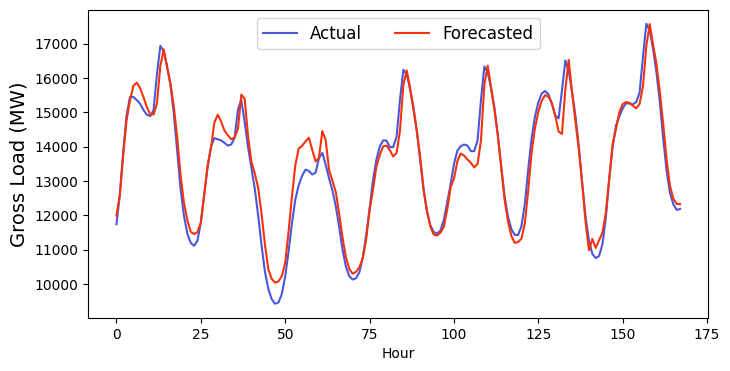

In [ ]:
Model = Sequential();
Model.add(InputLayer((sliding_window_size, len(exog_columns)+1)));
Model.add(LSTM(32, return_sequences=True));
Model.add(Dropout(0.2));
Model.add(LSTM(64));
Model.add(Dropout(0.2));
Model.add(Dense(8, 'relu'));
Model.add(Dense(1, 'linear'));
Model.summary();

# Create the ModelCheckpoint callback
cp_lstm = ModelCheckpoint(
    filepath='/tmp/checkpoint/LSTM.keras',
    save_weights_only=False,  # Save the entire model
    # monitor='val_accuracy',   # Monitor validation accuracy
    # mode='max',               # Look for maximum validation accuracy
    save_best_only=True,      # Only save the best model
    # verbose=1                 # Display messages when saving
    );

Model.compile(optimizer=Adam(learning_rate=0.005), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()]);
Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp_lstm]);
# Load the best model and forecast
best_model = tf.keras.models.load_model('/tmp/checkpoint/LSTM.keras');
# Make forecast and inverse transform
forecasted_normalized = best_model.predict(X_test);
forecasted = np.array((forecasted_normalized * y_test_std) + y_test_mean);
plot_and_report_accuracy_metrics(y_test, forecasted, 7);

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1426 - root_mean_squared_error: 0.3525 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1754
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1362
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1405
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Point Accuracy Metrics
 	 RMSE: 233.52, MAE: 165.38, MAPE: 1.19%


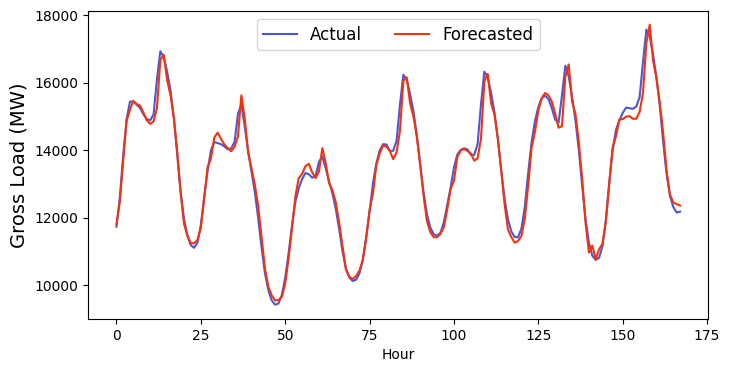

In [ ]:
# GRU
Model = Sequential();
Model.add(InputLayer((sliding_window_size, len(exog_columns)+1)));
Model.add(GRU(32));
Model.add(Dense(1, 'linear'));
Model.summary();

# Create the ModelCheckpoint callback
cp_lstm = ModelCheckpoint(
    filepath='/tmp/checkpoint/LSTM.keras',
    save_weights_only=False,  # Save the entire model
    # monitor='val_accuracy',   # Monitor validation accuracy
    # mode='max',               # Look for maximum validation accuracy
    save_best_only=True,      # Only save the best model
    # verbose=1                 # Display messages when saving
    );

Model.compile(optimizer=Adam(learning_rate=0.005), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()]);
Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp_lstm]);
# Load the best model and forecast
best_model = tf.keras.models.load_model('/tmp/checkpoint/LSTM.keras');
# Make forecast and inverse transform
forecasted_normalized = best_model.predict(X_test);
forecasted = np.array((forecasted_normalized * y_test_std) + y_test_mean);
plot_and_report_accuracy_metrics(y_test, forecasted, 7);

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 4, 60)          │        16,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 20)          │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,157 (121.71 KB)

 Trainable params: 31,157 (121.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2171 - root_mean_squared_error: 0.4450 - val_loss: 0.0581 - val_root_mean_squared_error: 0.2410
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0323 - root_mean_squared_error: 0.1796 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1589
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0230 - root_mean_squared_error: 0.1512 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Point Accuracy Metrics
 	 RMSE: 284.33, MAE: 208.8, MAPE: 1.52%


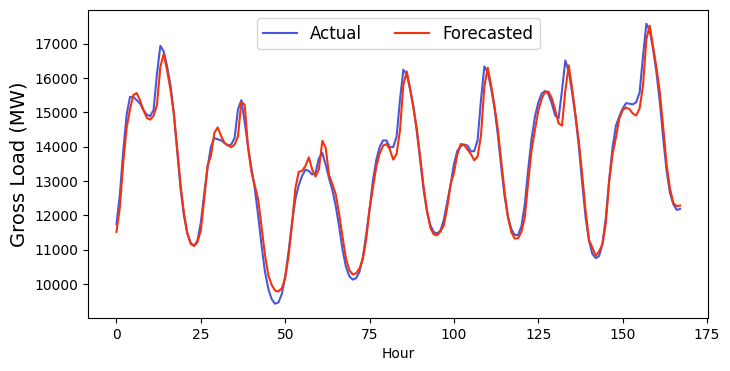

In [ ]:
# GRU + LSTM
Model = Sequential();
Model.add(InputLayer((sliding_window_size, len(exog_columns)+1)));
Model.add(LSTM(60, return_sequences=True));
Model.add(Dropout(0.2));
Model.add(Conv1D(20, kernel_size=3));
Model.add(GRU(50));
Model.add(Dropout(0.2));
Model.add(Dense(8, 'relu'));
Model.add(Dense(1, 'linear'));
Model.summary();

# Create the ModelCheckpoint callback
cp_lstm = ModelCheckpoint(
    filepath='/tmp/checkpoint/LSTM.keras',
    save_weights_only=False,  # Save the entire model
    # monitor='val_accuracy',   # Monitor validation accuracy
    # mode='max',               # Look for maximum validation accuracy
    save_best_only=True,      # Only save the best model
    # verbose=1                 # Display messages when saving
    );

Model.compile(optimizer=Adam(learning_rate=0.005), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()]);
Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp_lstm]);
# Load the best model and forecast
best_model = tf.keras.models.load_model('/tmp/checkpoint/LSTM.keras');
# Make forecast and inverse transform
forecasted_normalized = best_model.predict(X_test);
forecasted = np.array((forecasted_normalized * y_test_std) + y_test_mean);
plot_and_report_accuracy_metrics(y_test, forecasted, 7);

<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>7. Case Study Questions </font>** <a name="questions"></a>

There are two main activities for you to cover the medium and long-term forecasting of power demand. The first question wants you to determine the performance of the aforementioned techniques on a unit commitment (UC) problem.

## Medium-Term Forecasting

So far, we have examined the performance of the forecasting methods based on traditional RSME, MAE, and MAPE.
As mentioned in the lecture, the projected values are usually used in some downstream planning tasks, especially in the context of energy and sustainability. Therefore, it is better to use these metrics in conjuctino with a measure that indicates their performance on the actual task for which they are intended. For example, overestimation of load is less detrimental than underestimation in day-ahead planning as the latter may result in costly blackouts whereas the former may only require extra less costly reserve generators.
Here, the planning problem of interest is UC problem implemented in the following cell. UC common optimization model that determines the cost-effective hourly schedule for generators over the planning horizon (more on UC in later case studies).

**<font color='red'> Questions </font>**
1. Assume that the forecast period is 2 days (previously a week). Apply SARIMA, XGBoost, and LSTM with your own choice of hyperparameters to project the demand for the last 48 hours of the year. Rank the techniques by their performance.
 Evaluate the forecasted as well as values in the test set on the UC problem. Let $\hat{z}$ and $z$ be the resuling objective function values for the forecasted and actual demand. Compute the gap as $\frac{|\hat{z}-z|}{z}$. Instead of point accuracy measures, how would your ranking change if you compare the techniques based on the resulting gap?

2. The forecasting techniques are trained based on their loss function which is usually a function of the forecasted values and actual values in the training set. In light of previous question, do you think training these algorithms with two loss functions, one internal and the other from the downstream task, is a good idea? How do you think this is possible? Explain your answer without being too rigorous. The goal is to encourage brainstorming, exploring different options, and eliciting a cohesive answers.

<br>
<br>values
<br>

 ## Long-term Forecasting
Long-term forecasting in energy application is essential to prepare the infrastructure, evaluate the various policies, and assess the impact of different technologies.

**<font color='red'> Questions </font>**

1. The dataset folder 'load_time_series_data' contains the historical load for ISONE. Consider the data from 2000 to 2023 (24 years). Your task is to project the load for the year 2050 assuming 1\% annual load growth. To carry out this task:

 -  Read each file from 2000 to 2021. Consider the data for the years 2022 and 2023 as validation and test sets.
 - Add 'year' column to each file and concatenate them all to form the training dataset with about 23*8760 rows (some years are leap, so the number of rows will be slightly more).
 - Similar to the data preparation in the LSTM section, prepara the data with different window size (6, 12, 24, 168).
 - Train LSTM with the configuration of your choice.
 - Predict for the year 2023 and assess its accuracy.
 - Inflate the forecasted values considering the annual growth rate to obtain the projection for the target future year.

2. The projection carried out in the previous question ignores many factors that can influence the distribution of the demand by 2050. Some of these factors inclue climate change, electrification of end-use (more electric vehicles, heat pumps instead of gas furnace, etc.), population growth, electric-intensive industry (computing and datacenters), among others. How do you think some of these factors can be incorporated in the forecasting? Again, explain your answer without being too rigorous.


## Unit Commitment Problem
Make sure to install the required package as instructured in the following.

In [ ]:
# uncomment and install as follow
!pip install pyoptinterface[highs]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.4 MB/s eta 0:00:00


In [ ]:
import pyoptinterface as poi;
from pyoptinterface import highs;

def UC(demand):
    '''
    Parameters
    ----------
    demand : 1-dimensional numpy array

    this function solves a simple unit commitment problem for a given demand parameter.

    OUTPUT: objective function value
    '''
    demand = demand.reshape(-1);
    nGen = 15;
    nT = len(demand); # one week, hourly resolution

    # defien generator parameters
    Pmax = np.random.randint(int(0.6*demand.max()/nGen), int(1.6*demand.max()/nGen), size=nGen);
    Pmin = np.zeros(nGen);
    RampU = np.random.uniform(low=0.2, high=0.7, size=nGen);
    RampD = np.random.uniform(low=0.1, high=0.5, size=nGen);
    startup_cost = np.random.randint(10, 30, size=nGen);
    vom = np.random.randint(1, 5, size=nGen);
    initial_status = np.random.randint(0, 2, size=nGen);
    load_shedding_cost = 1e4; #typically between 10k and 30k per MWh

    # initialize the model
    Model = highs.Model();

    # define decison variables
    class DV():u=[]; p=[]; us=[]; shed=[];

    DV.u = Model.add_variables(range(nGen), range(nT), lb = 0,domain=poi.VariableDomain.Binary); #unit commitment
    DV.p = Model.add_variables(range(nGen), range(nT), lb = 0,domain=poi.VariableDomain.Continuous); # generation/production
    DV.su = Model.add_variables(range(nGen), range(nT), lb = 0,domain=poi.VariableDomain.Binary); # startup
    DV.shed = Model.add_variables(range(nT), lb = 0, domain=poi.VariableDomain.Continuous); # load shedding

    # define and add the objective function
    obj = poi.ExprBuilder();
    for t in range(nT):
        for g in range(nGen):obj += vom[g]*DV.p[g,t]+startup_cost[g]*DV.su[g,t];
        obj += load_shedding_cost*DV.shed[t];
    Model.set_objective(obj, poi.ObjectiveSense.Minimize);

    # constraints
    # balance equation
    for t in range(nT):Model.add_linear_constraint(poi.quicksum(DV.p[g,t] for g in range(nGen))+DV.shed[t], poi.Eq, demand[t]);

    # generation limit,  startup and ramping
    for g in range(nGen):
        for t in range(nT):
            Model.add_linear_constraint(DV.p[g,t], poi.Leq, Pmax[g]); # gen upper bound
            Model.add_linear_constraint(DV.p[g,t], poi.Geq, Pmin[g]); # gen lower bound
            if t>0:
                Model.add_linear_constraint(DV.su[g,t]-DV.u[g,t]+DV.u[g,t-1], poi.Geq, 0); # startup definition
                Model.add_linear_constraint(DV.p[g,t]-DV.p[g,t-1], poi.Leq, RampU[g]*Pmax[g]); # ramp up
                Model.add_linear_constraint(DV.p[g,t-1]-DV.p[g,t], poi.Leq, RampD[g]*Pmax[g]);# ramp down

    # solve and post-process
    Model.optimize();

    # calculate total generation and load shedding
    total_gen, total_unserved_power = 0, 0;
    for t in range(nT):
        for g in range(nGen): total_gen += Model.get_value(DV.p[g,t]);
        total_unserved_power += Model.get_value(DV.shed[t]);

    print(f'total generation: {round(total_gen)} MWh, \t total unserved power: {round(total_unserved_power)} MWh');
    # print(Model.get_model_attribute(poi.ModelAttribute.TerminationStatus));
    return np.round(Model.get_value(obj),2);

In [ ]:
# EXAMPLE
demand = data['gross_load_MW'].iloc[51*24:53*24].to_numpy();
obj = UC(demand)



total generation: 669804 MWh, 	 total unserved power: 0 MWh


<br>
<br>
<br>
<br>
<br>
<br>

# **<font color='blue'>8. References and Further Reading </font>** <a name="references"></a>

**Main references used in the tutorial portion of this case study:**

- Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. OTexts. ([link to the book](https://www.amazon.com/dp/0987507133?tag=otexts20), [website](https://otexts.com/fpp3/))
- Haben, S., Voss, M., & Holderbaum, W. (2023). Core concepts and methods in load forecasting: With applications in distribution networks (p. 331). Springer Nature. ([link to the book](https://link.springer.com/book/10.1007/978-3-031-27852-5))
- XGBoost Documentation ([website](https://xgboost.readthedocs.io/en/stable/index.html))
- Brownlee, J. (2018). Deep learning for time series forecasting: predict the future with MLPs, CNNs and LSTMs in Python. Machine Learning Mastery ([link to the book](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/))

<br>
<br>

From the vast topic of forecasting with its extensive literature, this case study only concers with a few techniques in point forecasting of power demand.  Apart from the main references mention above, here are a few resources for **further reading** .

- Petropoulos, F., Apiletti, D., Assimakopoulos, V., Babai, M. Z., Barrow, D. K., Taieb, S. B., ... & Ziel, F. (2022). Forecasting: theory and practice. International Journal of forecasting, 38(3), 705-871. [link](https://www.sciencedirect.com/science/article/pii/S0169207021001758)
- Alkhayat, G., & Mehmood, R. (2021). A review and taxonomy of wind and solar energy forecasting methods based on deep learning. Energy and AI, 4, 100060. [link](https://www.sciencedirect.com/science/article/pii/S2666546821000148)

- Hewamalage, H., Ackermann, K., & Bergmeir, C. (2023). Forecast evaluation for data scientists: common pitfalls and best practices. Data Mining and Knowledge Discovery, 37(2), 788-832. [link](https://arxiv.org/pdf/2203.10716)
- Elmachtoub, A. N., & Grigas, P. (2022). Smart “predict, then optimize”. Management Science, 68(1), 9-26. [link](https://pubsonline.informs.org/doi/pdf/10.1287/mnsc.2020.3922)



<br>
<br>
<br>
<br>
<br>
<br>
